# Régression à partir d'arbres de régression améliorée par la technique du Boosting

*Mot clé : splitter*

Les arbres de décision se divisent en 2 grandes catégories : les arbres de **classification** et les arbres de **régression**. Ce qui les distingue, c'est l'ensemble dans lequel évolue $y$ : dans le premier cas, $y$ est une variable catégorielle (il y a K classes possibles), dans le second cas, $y$ est une variable à valeurs dans une partie de $\mathbb{R}$.

Le problème des arbres binaires est que leur complexité croît exponentiellement par rapport à leur profondeur. Leur second inconvénient est leur tendance à faire du surapprentissage, au détriment de l'erreur de généralisation. Comment dans ce cas représenter des évolutions complexes sans surapprendre et être confronté à une complexité exponentielle ?

Le Boosting, popularisé entre autre par JH Friedman dans "Greedy function approximation: A gradient boosting machine.", apporte une solution. Le boosting consiste à partir d'une méthode de prédiction (DecisionTreeRegressor dans notre cas) pour construire un nouveau prédicteur qui est une somme pondérée d'un grand nombre de "versions" (seuls les paramètres changent) du prédicteur de base. Concrètement, cela revient à réaliser une prédiction une première fois, calculer les résidus (la première fois on calcule les résidus par rapport à la moyenne des $y$), faire une nouvelle prédiction sur les résidus, soustraire le 2e arbre aux anciens résidus pour obtenir de nouveaux résidus, et ainsi de suite. Cela permet de passer d'une complexité exponentielle à linéaire.

En pratique, avant de le soustraire aux anciens résidus, on multiple l'effet de l'arbre par un petit coefficient (typiquement $\leq 0.1$) ce qui permet d'équilibrer l'importance des arbres entre eux. Sans cela, le premier arbre prend bien plus d'importance que les suivants et celui nuit à la qualité de la prédiction. En revanche, l'introduction de ce "learning rate" impose d'introduire suffisamment d'arbres pour laisser la somme des prédicteurs atteindre le jeu initial. Si le nombre d'arbres est trop faible, la prédiction sera mauvaise! (voir au bas de ce doc)

Nous pourrions utiliser directement la méthode GradientBoostingRegressor de sklearn. Le problème avec cette méthode est qu'elle utilise des arbres de décision qui calculent les seuils par moyenne arithmétique des frontières des régions. Concrètement, si les valeurs de mes features sont x=1;2;3;4;5;6;7;8;9;10, les seuls seuils de régression possibles sont 1.5;2.5;3.5;4.5;5.5;...;9.5. Comme il ne paraît plus intéressant de générer les seuils aléatoirement pour chaque noeud (ce qui permet de lisser la courbe pour moins lui donner un air d'escalier), le boosting est explicité pour pouvoir activer directement le paramètre **splitter** sur "random" (au lieu de la valeur par défaut "best"). Le paramètre **splitter** est un paramètre clé de la méthode DecisionTreeRegressor. Pour en savoir voir en bas du doc.

Comme exemple pratique on prend une situation très simple: les caractéristiques sont les $i$ dans $[|1,10|]$ et ont pour ordonnée $i$. On s'attend évidemment à obtenir une prédiction ressemblant à une droite.

Pour aller plus vite le code ci-dessous est partiellement écrit par ChatGPT et a été vérifié et retravaillé pour correspondre à ce que je veux montrer.

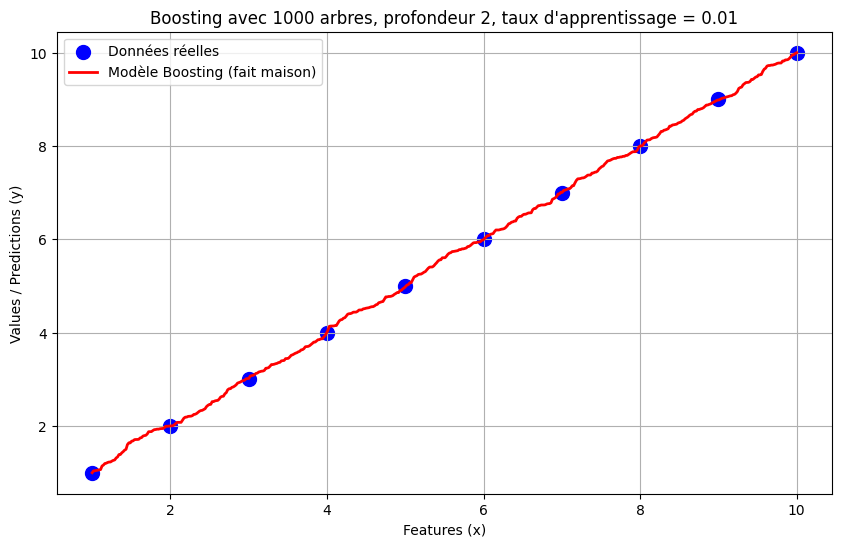

'\n# Affichage des trois premiers arbres\nfor i in range(min(n_estimators, 3)):\n    plt.figure(figsize=(12, 8))\n    tree = estimators[i]  # Extraire l\'arbre i\n    from sklearn.tree import plot_tree\n    plot_tree(tree, filled=True, feature_names=["i"], rounded=True)\n    plt.title(f"Arbre de décision {i+1} du modèle de boosting (fait maison)")\n    plt.show()\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Génération des points (i, i) pour i dans [|1, n|]
n = 10
X = np.arange(1, n+1).reshape(-1, 1)
Xtilde = np.linspace(1, n, 500).reshape(-1, 1)
y = np.arange(1, n+1)

# Paramètres du boosting
learning_rate = 0.01
n_estimators = 1000  # nombre d'arbres
max_depth = 2

# Initialisation du modèle
y_pred = np.zeros_like(y, dtype=float)

# Stocker chaque arbre
estimators = []

# Gradient Boosting "maison"
for i in range(n_estimators):
    residuals = y - y_pred
    tree = DecisionTreeRegressor(max_depth=max_depth, splitter="random")   # le point clé, c'est la variable splitter, qui est choisie "random" pour que le seuil (threshold) soit choisi aléatoirement
    tree.fit(X, residuals)
    y_pred += learning_rate * tree.predict(X) # on multiplie le modèle par le petit taux d'apprentissage avant de l'ajouter au reste du grand modèle
    estimators.append(tree)

# Prédictions sur les points Xtilde
ytilde_pred = np.zeros(Xtilde.shape[0])
for tree in estimators:
    ytilde_pred += learning_rate * tree.predict(Xtilde)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="blue", label="Données réelles", s=100)  # points réels
plt.plot(Xtilde, ytilde_pred, color="red", label="Modèle Boosting (fait maison)", linewidth=2)  # prédictions
plt.title(f"Boosting avec {n_estimators} arbres, profondeur {max_depth}, taux d'apprentissage = {learning_rate}")
plt.xlabel("Features (x)")
plt.ylabel("Values / Predictions (y)")
plt.legend()
plt.grid(True)
plt.show()
'''
# Affichage des trois premiers arbres
for i in range(min(n_estimators, 3)):
    plt.figure(figsize=(12, 8))
    tree = estimators[i]  # Extraire l'arbre i
    from sklearn.tree import plot_tree
    plot_tree(tree, filled=True, feature_names=["i"], rounded=True)
    plt.title(f"Arbre de décision {i+1} du modèle de boosting (fait maison)")
    plt.show()
'''


# Ce qu'on sait maintenant faire

Pour aller plus vite le code ci-dessous est partiellement écrit par ChatGPT et a été vérifié et retravaillé pour correspondre à ce que je veux montrer.

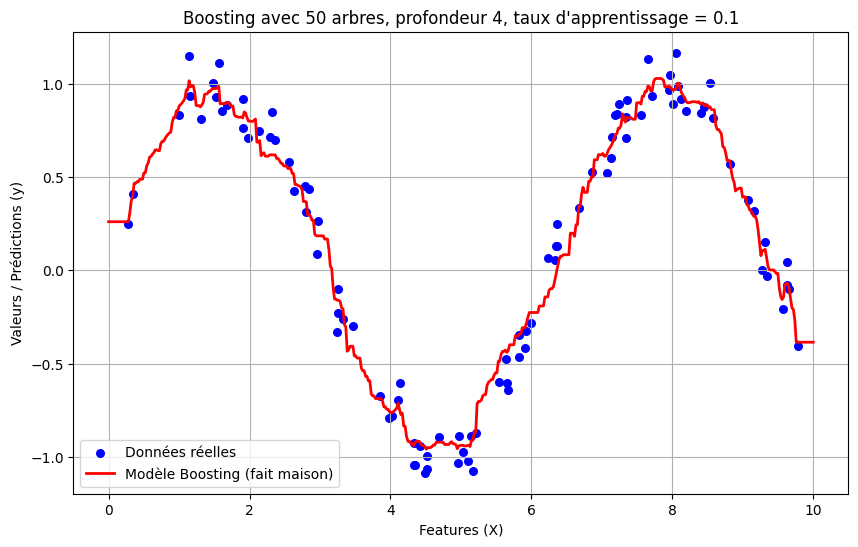

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Génération des données non-linéaires
n = 100  # nombre de points
X = np.sort(np.random.rand(n) * 10).reshape(-1, 1)  # Générer des données aléatoires sur l'intervalle [0, 10]
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])  # Fonction sinus avec du bruit ajouté

Xtilde = np.linspace(0, 10, 500).reshape(-1, 1)

# Paramètres du boosting
learning_rate = 0.1
n_estimators = 50
max_depth = 4

# Initialisation du modèle
y_pred = np.zeros_like(y, dtype=float)

# Stocker chaque arbre
estimators = []

# Gradient Boosting "maison"
for i in range(n_estimators):
    residuals = y - y_pred  # calcul des résidus
    tree = DecisionTreeRegressor(max_depth=max_depth, splitter="random")
    tree.fit(X, residuals)
    y_pred += learning_rate * tree.predict(X)
    estimators.append(tree)

# Prédictions sur les points Xtilde
ytilde_pred = np.zeros(Xtilde.shape[0])
for tree in estimators:
    ytilde_pred += learning_rate * tree.predict(Xtilde)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="blue", label="Données réelles", s=30)  # points réels avec taille de points ajustée
plt.plot(Xtilde, ytilde_pred, color="red", label="Modèle Boosting (fait maison)", linewidth=2)  # prédictions
plt.title(f"Boosting avec {n_estimators} arbres, profondeur {max_depth}, taux d'apprentissage = {learning_rate}")
plt.xlabel("Features (X)")
plt.ylabel("Valeurs / Prédictions (y)")
plt.legend()
plt.grid(True)
plt.show()


# Informations sur splitter

La classe DecisionTreeRegressor hérite d'une autre classe appelée BaseDecisionTree dont le premier argument, splitter, peut prendre 2 valeurs : "best" ou "random".

Définition de splitter: https://github.com/scikit-learn/scikit-learn/blob/eec6ef005c89335309a341fd8be6d89b53bf97af/sklearn/tree/_classes.py#L97C1-L98C1

DecisionTreeRegressor hérite de BaseDecisionTree: https://github.com/scikit-learn/scikit-learn/blob/eec6ef005c89335309a341fd8be6d89b53bf97af/sklearn/tree/_classes.py#L1095

Par défaut, splitter vaut "best" pour DecisionTreeRegressor: https://github.com/scikit-learn/scikit-learn/blob/eec6ef005c89335309a341fd8be6d89b53bf97af/sklearn/tree/_classes.py#L1320

De même pour DecisionTreeClassifier: https://github.com/scikit-learn/scikit-learn/blob/eec6ef005c89335309a341fd8be6d89b53bf97af/sklearn/tree/_classes.py#L944

Le fichier _classes.py (accessible depuis les 2 liens précédents) est intéressant car il donne toutes les valeurs par défaut de DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier et ExtraTreeRegressor (les deux derniers étant respectivement des classes enfants de DecisionTreeClassifier et de DecisionTreeRegressor). Par défaut, les 2 premières classes sont sur splitter="best" et les 2 dernières sur splitter="random". Le fichier _classes.py donne aussi accès aux critères de split. Pour la classification: Gini, entropie ou log-loss. Pour la régression: mse (squared error), mse de friedman, mae (absolute error) ou Poisson.

Dans le fichier splitter.pyx, on peut constater qu'il y a deux façons de calculer current_split.threshold (qui est exactement la donnée que nous cherchons : le seuil):
* Ligne 457 par moy arithmétique : https://github.com/scikit-learn/scikit-learn/blob/eec6ef005c89335309a341fd8be6d89b53bf97af/sklearn/tree/_splitter.pyx#L457C1-L458C1
* Ligne 672 par tirage de loi uniforme : https://github.com/scikit-learn/scikit-learn/blob/eec6ef005c89335309a341fd8be6d89b53bf97af/sklearn/tree/_splitter.pyx#L672C1-L673C1

La méthode de seuil est indirectement contrôlée par le paramètre splitter, qu'on peut spécifier dans la méthode DecisionTreeRegressor.

# Ce qui se passe quand il n'y a pas assez d'arbres alors que le learning rate est petit

(J'ai juste copié le premier code et modifié n_estimators en l'abaissant de 1000 à 100)

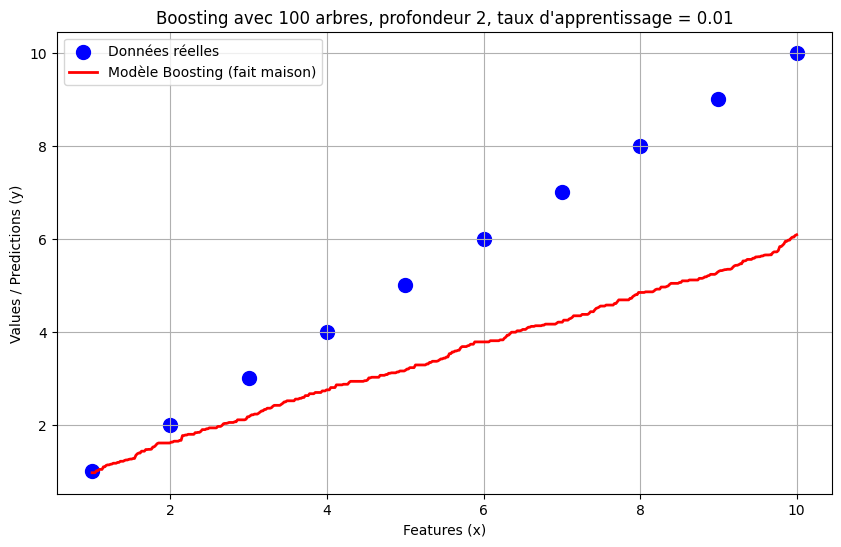

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Génération des points (i, i) pour i dans [|1, n|]
n = 10
X = np.arange(1, n+1).reshape(-1, 1)
Xtilde = np.linspace(1, n, 500).reshape(-1, 1)
y = np.arange(1, n+1)

# Paramètres du boosting
learning_rate = 0.01
n_estimators = 100  # nombre d'arbres
max_depth = 2

# Initialisation du modèle
y_pred = np.zeros_like(y, dtype=float)

# Stocker chaque arbre
estimators = []

# Gradient Boosting "maison"
for i in range(n_estimators):
    residuals = y - y_pred
    tree = DecisionTreeRegressor(max_depth=max_depth, splitter="random")   # le point clé, c'est la variable splitter, qui est choisie "random" pour que le seuil (threshold) soit choisi aléatoirement
    tree.fit(X, residuals)
    y_pred += learning_rate * tree.predict(X) # on multiplie le modèle par le petit taux d'apprentissage avant de l'ajouter au reste du grand modèle
    estimators.append(tree)

# Prédictions sur les points Xtilde
ytilde_pred = np.zeros(Xtilde.shape[0])
for tree in estimators:
    ytilde_pred += learning_rate * tree.predict(Xtilde)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="blue", label="Données réelles", s=100)  # points réels
plt.plot(Xtilde, ytilde_pred, color="red", label="Modèle Boosting (fait maison)", linewidth=2)  # prédictions
plt.title(f"Boosting avec {n_estimators} arbres, profondeur {max_depth}, taux d'apprentissage = {learning_rate}")
plt.xlabel("Features (x)")
plt.ylabel("Values / Predictions (y)")
plt.legend()
plt.grid(True)
plt.show()

Pour vraiment comprendre l'intuition derrière ce phénomène, on peut même encore simplifier (en prenant splitter="best" et en prenant un learning rate facile à interpréter : 0.5):

(J'ai juste copié le premier code et modifié n_estimators, learning_rate, max_depth et splitter)

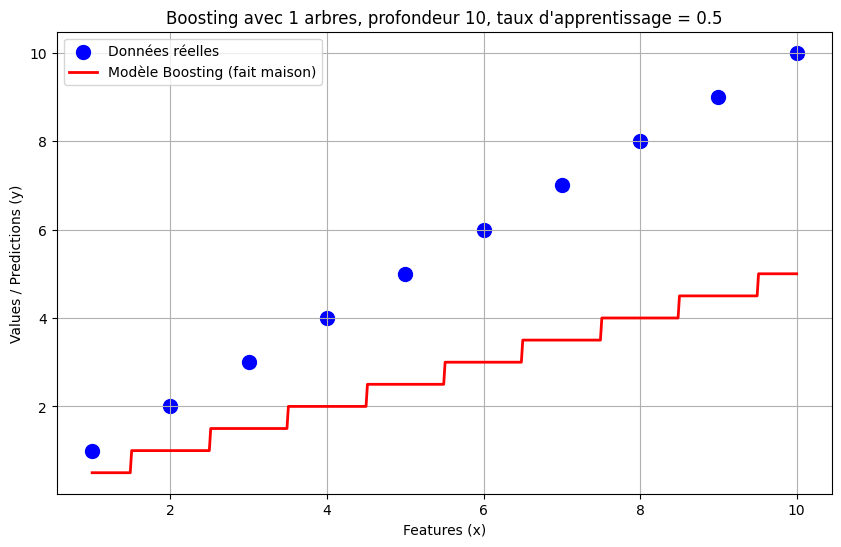

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Génération des points (i, i) pour i dans [|1, n|]
n = 10
X = np.arange(1, n+1).reshape(-1, 1)
Xtilde = np.linspace(1, n, 500).reshape(-1, 1)
y = np.arange(1, n+1)

# Paramètres du boosting
learning_rate = 0.5
n_estimators = 1  # nombre d'arbres
max_depth = 10

# Initialisation du modèle
y_pred = np.zeros_like(y, dtype=float)

# Stocker chaque arbre
estimators = []

# Gradient Boosting "maison"
for i in range(n_estimators):
    residuals = y - y_pred
    tree = DecisionTreeRegressor(max_depth=max_depth, splitter="best")   # le point clé, c'est la variable splitter, qui est choisie "random" pour que le seuil (threshold) soit choisi aléatoirement
    tree.fit(X, residuals)
    y_pred += learning_rate * tree.predict(X) # on multiplie le modèle par le petit taux d'apprentissage avant de l'ajouter au reste du grand modèle
    estimators.append(tree)

# Prédictions sur les points Xtilde
ytilde_pred = np.zeros(Xtilde.shape[0])
for tree in estimators:
    ytilde_pred += learning_rate * tree.predict(Xtilde)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="blue", label="Données réelles", s=100)  # points réels
plt.plot(Xtilde, ytilde_pred, color="red", label="Modèle Boosting (fait maison)", linewidth=2)  # prédictions
plt.title(f"Boosting avec {n_estimators} arbres, profondeur {max_depth}, taux d'apprentissage = {learning_rate}")
plt.xlabel("Features (x)")
plt.ylabel("Values / Predictions (y)")
plt.legend()
plt.grid(True)
plt.show()

On voit ci-dessus (situation 1 arbre, learning rate 0.5, max_depth=10, splitter="best") que l'arbre ne contribue à la prédiction qu'à hauteur de 50% de sa prédiction normale. Cet exemple simple permet de constater que si le learning rate est trop faible et le nombre d'arbres pas assez important, on ne permet pas à la prédiction d'être pertinente car elle n'atteint même pas les points du jeu de données! Il faut donc veiller à avoir un learning rate faible (pour assurer une plus grande robustesse) mais à utiliser aussi un nombre d'arbres important pour simplement permettre au modèle global d'être pertinent!